In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

In [20]:
import dembuilder as db
import numpy as np
import xarray as xr 
import os

### Raster

Currently uses a rectilinear grid to compile all the bathymetry into a raster of a specified resolution with in a defined bounding box (bbox)

In [24]:
#pull in DFM grid 
gpath = r'Y:\CUTTLER_DampierArchipelago_DBCA\Data\Modelling\DFM-SWAN\Testing_model_development\ModelInputs\Dampier_v6_coupled_wave_timeseries_wind\FlowFM'
fname = 'Dampier_v6_net.nc'
gfile = os.path.join(gpath,fname)

dfm_grid = xr.open_dataset(gfile)

xmin = dfm_grid.mesh2d_node_x.min()
xmax = dfm_grid.mesh2d_node_x.max()
ymin = dfm_grid.mesh2d_node_y.min()
ymax = dfm_grid.mesh2d_node_y.max()

In [25]:
#build bounding box 
bbox=np.zeros(4)
bbox[0] = xmin #left
bbox[1] = ymin #bottom
bbox[2] = xmax #right
bbox[3] = ymax #top
newRaster = db.Raster(bbox=bbox, resolution=30, epsgCode=28350)

### SamplePointReader

The sample point reader reads a datafile, optionally crops a box out of the data and drops missing values. Calling SamplePointReader.load() will read the data from disk and return a Samples object.

In [27]:
#first read in Dampier SDB
rpath = r'E:\Active_Projects\CUTTLER_DampierArchipleago_DBCA\Data\Bathy\Dampier_SDB'
rfile = 'Dampier_SDB.tif'
sampleReader = db.SamplePointReader(os.path.join(rpath,rfile),cropTo=bbox)
samples = sampleReader.load()

E:\Active_Projects\CUTTLER_DampierArchipleago_DBCA\Data\Bathy\Dampier_SDB\Dampier_SDB.tif
SamplePointFormat.GeoTIFF
Source projection: +proj=utm +zone=50 +south +datum=WGS84 +units=m +no_defs


### SamplePoints

SamplePoints is an object with three numpy arrays for the x, y and z coordinates of the samples.

In [28]:
samples

Total samples: 43091098 
 x=array([482203.72115085, 482213.72115085, 482223.72115085, ...,
       409853.72115085, 409863.72115085, 409873.72115085]) 
 y=array([7750156.99463998, 7750156.99463998, 7750156.99463998, ...,
       7677086.99463998, 7677086.99463998, 7677086.99463998]) 
 z=array([-35.91296387, -35.18508911, -35.33282852, ...,   2.95968556,
         3.20629096,   3.36480284])

Before any loaded samples can be used to fill the raster, you must specify the type of boundary to use to limit extrapolation. The boundary types are called

In [30]:
[t for t in db.BoundaryPolygonType]

[<BoundaryPolygonType.Box: 0>,
 <BoundaryPolygonType.ConvexHull: 1>,
 <BoundaryPolygonType.ConcaveHull: 2>,
 <BoundaryPolygonType.Polygon: 3>]

Generate a box boundary

In [ ]:
samples.generateBoundary(db.BoundaryPolygonType.ConcaveHull,threshold=250)

C:\Users\00084142\OneDrive - The University of Western Australia\CUTTLER_GitHub\dembuilder\notebooks\..\dembuilder\dembuilder.py:578: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(points) < 4:
C:\Users\00084142\OneDrive - The University of Western Australia\CUTTLER_GitHub\dembuilder\notebooks\..\dembuilder\dembuilder.py:592: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  coords = np.array([point.coords[0] for point in points])


We can make a scatter plot of the samples by calling .plot()

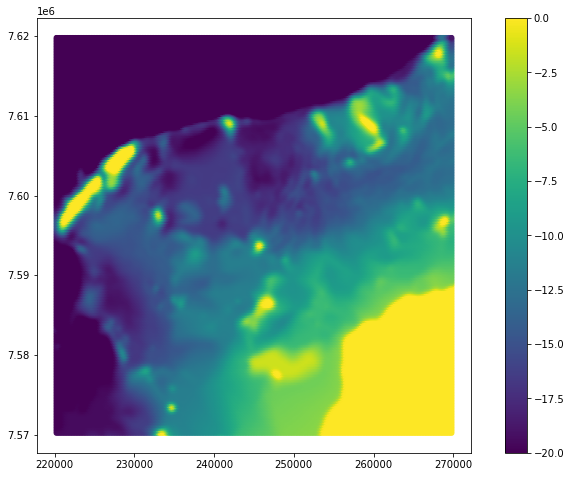

In [9]:
samples.plot()

Make another set of random samples for demonstration purposes

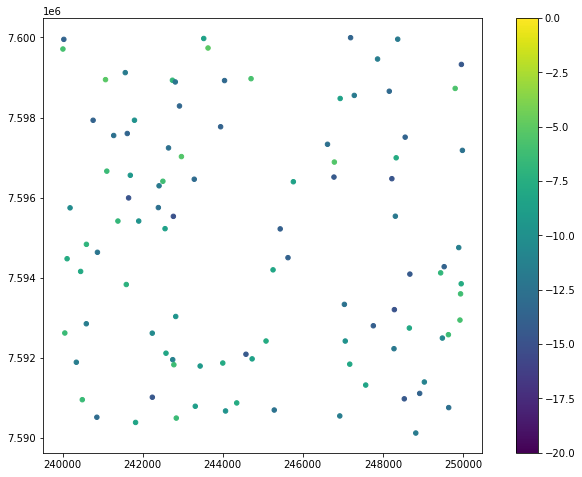

In [11]:
x = np.random.rand(100) * 10000 + 240000
y = np.random.rand(100) * 10000 + 7590000
z = np.random.rand(100) * 10 - 15 
randomSamples = db.SamplePoints(x,y,z)
randomSamples.plot()

The concave hull can take quite some time to calculate if there are many samples and you should specify a threshold distance beyond which the edges of the triangulation will be weeded. 

In [13]:
randomSamples.generateBoundary(db.BoundaryPolygonType.ConcaveHull,threshold=1500)

C:\Users\00084142\OneDrive - The University of Western Australia\CUTTLER_GitHub\dembuilder\notebooks\..\dembuilder\dembuilder.py:578: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(points) < 4:
C:\Users\00084142\OneDrive - The University of Western Australia\CUTTLER_GitHub\dembuilder\notebooks\..\dembuilder\dembuilder.py:592: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  coords = np.array([point.coords[0] for point in points])
C:\Users\00084142\OneDrive - The University of Western Australia\CUTTLER_GitHub\dembuilder\notebooks\..\dembuilder\dembuilder.py:624: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  r

### The Raster object can be filled with samples using a variety of resampling methods

In [14]:
[t for t in db.ResampleMethods]

[<ResampleMethods.BlockAvg: 0>,
 <ResampleMethods.Linear: 1>,
 <ResampleMethods.Cubic: 2>,
 <ResampleMethods.SmoothCubic: 3>,
 <ResampleMethods.BsplineLSQ: 4>,
 <ResampleMethods.BsplineSmooth: 5>,
 <ResampleMethods.Rbf: 6>,
 <ResampleMethods.Kriging: 7>,
 <ResampleMethods.NaturalNeighbour: 8>]

If the samples are sparse compared to the raster grid resolution then the interpolation methods > 1 (Linear) should be used. Otherwise block averaging (also referred to as grid cell averaging) is likely the preferred method

Firstly we will linearly interpolate the randome samples, only inside the calculated ConcaveHull

In [15]:
randomSamples.resample(newRaster,method=db.ResampleMethods.Linear)

Using 100 SamplePoints to fill 95 raster points with in the SamplePoints boundary


Plot the result

(<Figure size 864x576 with 2 Axes>, <AxesSubplot:>)

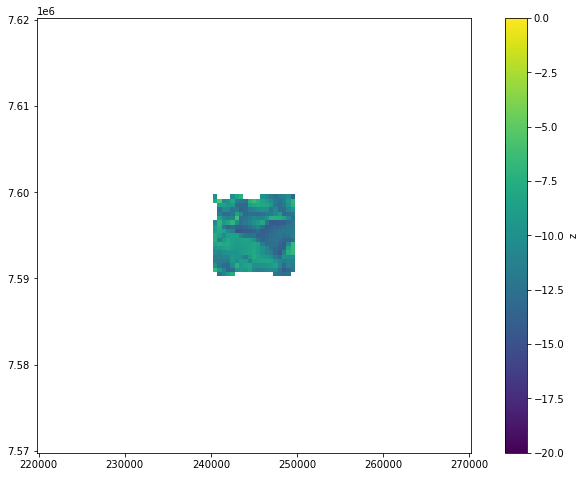

In [16]:
newRaster.plot()

In [17]:
samples.resample(newRaster,method=db.ResampleMethods.BlockAvg)

(<Figure size 864x576 with 2 Axes>, <AxesSubplot:>)

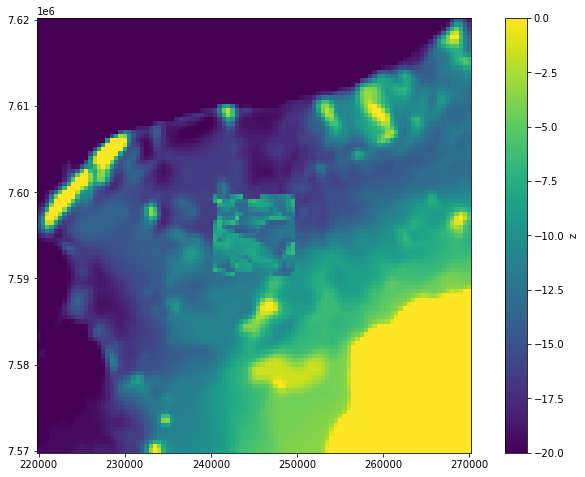

In [18]:
newRaster.plot()

### Save out the resulting raster as a GeoTIFF...

In [17]:
newRaster.saveToFile('tempRaster.tiff')

### ... or extract the samples and save as an XYZ file

In [18]:
newRaster.getSamples().saveXYZ('tempRaster.xyz')

### Saved rasters can be loaded directly too

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1088eda940>)

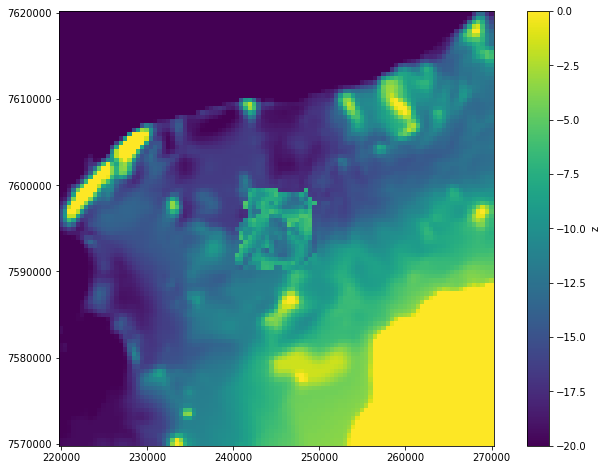

In [19]:
loadedRaster = db.Raster.loadFromFile('tempRaster.tiff')
loadedRaster.plot()